# SMARTS/SMIRKS Highlighter

This notebook was created to help with molecule visualization using substructure searches. 
You provide 
- a list of molecules (demonstrated here with SMILES strings, but you could set it up to read in a file)
- a SMILES/SMARTS/SMIRKS you want to match to the molecule

Then an image is created for every substructure in each molecule matched by that SMILES/SMARTS/SMIRKS.

## What wil you see

In an example, we decided to look for the SMIRKS `'[#6:1](=[#8])-[#8H1:2]'` which describes the single bond between the carbon and protonated oxygen in a carboxylic acid. In the visualization the atoms involved in the bond specified by the "tagged" atoms `:1` and `:2` will be cicled in blue. All atoms in the substructure, the two atoms in the bond and the double bond to the other oxygen will be highlighted in pink. 

In this example we answer the questions below as:

1. `smiles = ['COC(=O)CC(=O)O']`
2. `subsearch = '[#6:1](=[#8])-[#8H1:2]'`
3. `see_hydrogens = False`
4. There are no aromatic rings in this molecule so this an irrelevant setting here.
5. `save_file = True` and `file_formula = "images/COOH_example_%i_%i.png"`

Which results in this image:
![title](images/COOH_example_0_0.png)

**Import modules**

In [1]:
from openeye import oechem
import openeye.oedepict as oedepict
import IPython
from IPython.display import display, Image
from openforcefield.utils import read_molecules

## `DepictMatch`

This is the actual function used for generating the molecul images

In [73]:
def  depictMatch(mol, match, supH = True, idx_atoms=list(), width=500, height=200, fn=None):
    """
    Parameters
    ----------
    mol: oemol
    match: an oematch object generated during a substructure search
        This match will be highlighted in Salmon color
    supH: boolean (default = True)
        suppress hydrogens, that is when True the hydrogens are not shown
    idx_atoms: list (or list like) of atom indices
        These are atom indices you also want indicated, they will have blue circles around the outside.
        For example, you may want to provide the atoms "tagged" with a smirks index
        If none provided then only the match object will be highlighted.
    width: float (default = 500)
    heigh: float (default = 200)
    fn: path to image file (default = None)
        if a path to an image file (i.e. png, pdf, jpeg) is provided then the image
        returned by this function is also rendered into that file. 
        Note - this can be an absolute or relative path to the desired output.
        When None no file is created.
    
    Returns
    -------
    img: OEImage
        OEImages can be saved to image files (png, pdf, jpeg, etc) with:
            oedepict.OEWriteImage('path/to/file', img)
        or these can be rendered directly in a notebook with:
            from IPython.display import display, Image
            display(Image(oedepict.OEWriteImageToString("png",img)))
    """
    atom_bond_set = oechem.OEAtomBondSet()
    for atom in mol.GetAtoms():
        if atom.GetIdx() in idx_atoms:
            atom_bond_set.AddAtom(atom)
            for bond in atom.GetBonds():
                nbr_atom = bond.GetNbr(atom)
                if (nbr_atom.GetIdx() in idx_atoms) and nbr_atom.GetIdx() > atom.GetIdx():
                    atom_bond_set.AddBond(bond)
    
    dopt = oedepict.OEPrepareDepictionOptions()
    dopt.SetDepictOrientation( oedepict.OEDepictOrientation_Horizontal)
    dopt.SetSuppressHydrogens(supH)
    oedepict.OEPrepareDepiction(mol, dopt)
    
    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    opts.SetAtomColorStyle(oedepict.OEAtomColorStyle_WhiteMonochrome)
    disp = oedepict.OE2DMolDisplay(mol, opts)
    
    # Highlight indexed atoms
    hstyle = oedepict.OEHighlightStyle_Cogwheel
    hcolor = oechem.OEColor(oechem.OELightBlue)
    if not atom_bond_set.IsEmpty():
        oedepict.OEAddHighlighting(disp, hcolor, hstyle, atom_bond_set)
    
    # Highlight whole match
    hstyle = oedepict.OEHighlightStyle_BallAndStick
    hcolor = oechem.OEColor(oechem.OELightSalmon)
    oedepict.OEAddHighlighting(disp, hcolor, hstyle, match)
    
    img = oedepict.OEImage(width, height)
    oedepict.OERenderMolecule(img,disp)
    
    if fn is not None:
        if not oedepict.OEWriteImage(fn, img):
            print("OE could not write image to file %s" % fn)
    return img

## 1. Create a list of molecules

In the default this is done by allowing the user to specify SMILES and then created OEMols from those. If you would prefer to load molecules from a file you could do that instead. 

In [74]:
# start with a list of SMILES:
smiles = ['COC(=O)CC(=O)O']
mols = list()
for s in smiles:
    m = oechem.OEMol()
    if oechem.OESmilesToMol(m, s):
        oechem.OEAddExplicitHydrogens(m)
        mols.append(oechem.OEMol(m))
    else:
        print("could not parse smiles: ", s)

## 2. Chose a Substructure search string

This can be a SMILES, SMARTS, or SMIRKS string. 
Note that if there are "tagged"  atoms in the SMARTS or SMIRKS, indicated with a `:n` in the atom, those atoms will be indicated in the images with a blue circle around the outside.

In [75]:
# write a string for your substructure search
subsearch = '[#6:1](=[#8])-[#8H1:2]'

## 3. Do you want to see all hydrogens in your image?

Hydrogens on heteroatoms will always be shown. If you would like to see all hydrogens on carbons switch this to `True`. If you include hydrogens in your subsearch pattern, 

In [76]:
see_hydrogens = False

## 4. Should we use the OpenEye MDL aromaticity model?

The MDL aromaticity model is the one currently implemented by the [SMIRNOFF](https://github.com/openforcefield/openforcefield/blob/master/The-SMIRNOFF-force-field-format.md) force fields for a complete descriptio of this model see the corresponding [OpenEye Documentation](https://docs.eyesopen.com/toolkits/python/oechemtk/aromaticity.html#section-aromaticity-models)

In [77]:
mdl = False

## 5. Save output to file

If you would like your images saved to an image file (`png`, `pdf`, etc.) you can specify a path to that file with two `%i` symbols. The first number is filled in with the SMILES index, the second with the match index. 

If you do not want your matches saved to a file then set `save_file = False`

In [78]:
save_file = True
if save_file:
    file_formula = "images/COOH_example_%i_%i.png"

### Search each molecule for the pattern

COC(=O)CC(=O)O True
{1: 5, 2: 7}


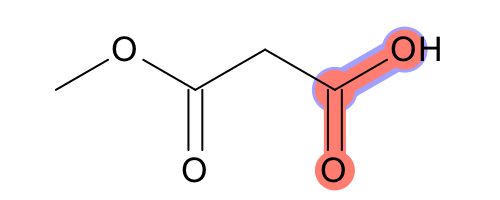

In [79]:
unique = False
for smi_idx, mol in enumerate(mols):
    if mdl:
        oechem.OEClearAromaticFlags(mol)
        oechem.OEAssignAromaticFlags(mol, oechem.OEAroModelMDL)
        oechem.OEAssignHybridization(mol)
    
    # make a substructure search object
    qmol = oechem.OEQMol()
    if not oechem.OEParseSmarts(qmol, subsearch):
        print("FAILED to parse")
        break
    ss = oechem.OESubSearch(qmol)
    
    print(oechem.OEMolToSmiles(mol), ss.SingleMatch(mol))
    
    for match_idx, match in enumerate(ss.Match(mol, unique)):
        # get indexed atoms (if they exist)
        idx_dict = dict()
        for ma in match.GetAtoms():
            pat = ma.pattern.GetMapIdx()
            if pat > 0:
                idx_dict[pat] = ma.target.GetIdx()
                
        print(idx_dict)
        # print(subsearch)
        idx_atoms = [idx_dict[k] for k in sorted(idx_dict.keys())]
        if save_file:
            fn = file_formula % (smi_idx, match_idx)
        else:
            fn = None
        img = depictMatch(mol,match,supH=not see_hydrogens, idx_atoms=idx_atoms, fn=fn)
        display(Image(oedepict.OEWriteImageToString("png",img)))